In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
from  partie1 import GRUEncoderGD, GRUDecoderGD, GRUDecoderDG, GRUEncoderDG, BiGRUDecoder, BiGRUEncoder
from partie1 import LSTMEncoder, LSTMDecoder
from partie1 import TensorProductEncoder

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
##### entiers 0-10 
# def generate_data(batch_size, seq_len, min_val=0, max_val=10):
#     return torch.randint(min_val, max_val, (batch_size, seq_len))


def generate_data(batch_size, seq_len, input_size):
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # rôles
    return data, roles

def precision(predicted, target):
    correct = (predicted.argmax(dim=-1) == target).float()
    return correct.mean().item() * 100

def plot_tensors(tensor1, tensor2, labels=("Tensor 1", "Tensor 2")):

    tensor1 = tensor1.flatten()
    tensor2 = tensor2.flatten()
    x_indices = range(len(tensor1))


    plt.figure(figsize=(10, 6))
    plt.plot(x_indices, tensor1.detach().numpy(), label=labels[0], marker='o')
    plt.plot(x_indices, tensor2.detach().numpy(), label=labels[1], marker='x')

    plt.title("Comparaison des valeurs des tenseur en fonction de l'indice")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# **Eval / Test**

## debug

Pour comprendre les différences d'accuracy en sortie du décodeur :

loss : 0.02303837612271309
tensor([[[ 0.6576,  0.9734,  0.7410, -0.0685,  0.1347, -0.3259,  0.3114,
          -0.2388, -0.1808, -0.9748, -0.7869,  0.1173,  0.9574, -0.1186,
           0.4641, -0.5958, -0.1016, -0.1356, -0.8724, -0.7300,  0.2727,
          -0.6446, -0.0704,  0.9822,  0.3951, -0.1665, -0.9149, -0.8181,
          -0.6696,  0.2201, -0.3487, -0.4837]]], grad_fn=<StackBackward0>)
tensor([[ 0.5513,  0.8801,  0.6952, -0.2068,  0.3103, -0.2036,  0.1118, -0.2583,
          0.0858, -0.9333, -0.7233,  0.0166,  0.9815, -0.1826,  0.3839, -0.5744,
          0.0127, -0.0883, -0.8863, -0.7261,  0.7104, -0.6144,  0.1918,  0.9552,
          0.3833, -0.2526, -0.9214, -0.3850, -0.5446,  0.3621, -0.3936, -0.5140]],
       grad_fn=<AddmmBackward0>)


/tmp/ipykernel_4038922/2984428505.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load('./models/GD/gru_enc.pth')
/tmp/ipykernel_4038922/2984428505.py:1

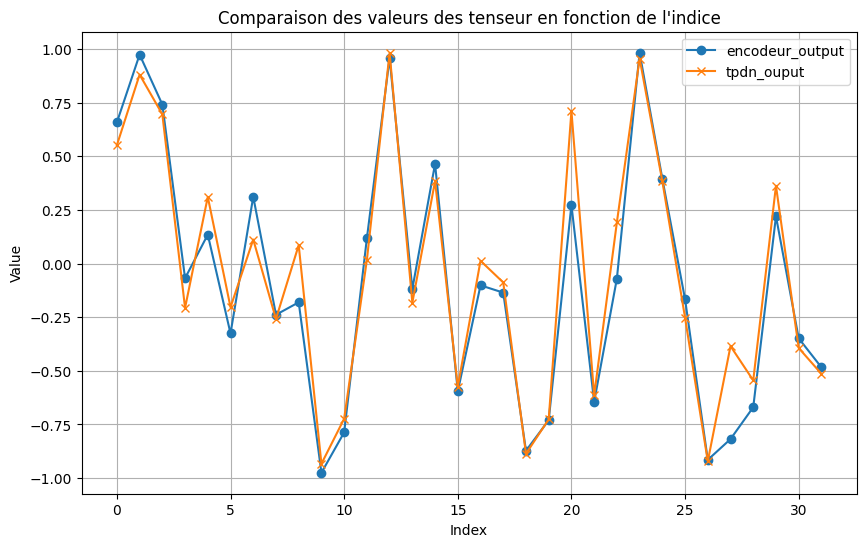

tensor([[8, 5, 3, 2, 7, 0, 2, 7, 1, 7]])
tensor([[8, 5, 8, 3, 7, 2, 6, 8, 7, 3]])
tensor([[8, 5, 3, 2, 0, 0, 2, 7, 1, 7]])
30.000001192092896
89.99999761581421


In [9]:


# Hyperparameters
input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10
seq_len = 10
batch_size = 1 # Utiliser plusieurs exemples pour analyse

criterion = nn.MSELoss()


encoder = torch.load('./models/GD/gru_enc.pth')
tpdnencoder = torch.load('./models/GD/tpdn_gru.pth')
decoder = torch.load("./models/GD/gru_dec.pth")

encoder.eval()
tpdnencoder.eval()
decoder.eval()

### TEST
data, roles = generate_data(batch_size, seq_len, input_size)

encoder_output = encoder(data)  # (seq_len, batch_size, hidden_size)
tpdn_output = tpdnencoder(data, roles)  # (batch_size, hidden_size)
loss = criterion(encoder_output, tpdn_output)

print(f"loss : {loss}")
print(encoder_output)
print(tpdn_output)

seq_len_tensor = torch.tensor([seq_len])

reconstructed_tpdn = decoder(tpdn_output.unsqueeze(0), seq_len_tensor)
reconstructed_gru = decoder(encoder_output, seq_len_tensor)

plot_tensors(encoder_output.squeeze(0)  , tpdn_output, labels = ("encodeur_output","tpdn_ouput"))
print(data)
print(reconstructed_tpdn.argmax(dim=-1))
print(reconstructed_gru.argmax(dim=-1))
print( precision(reconstructed_tpdn, data))
print( precision(reconstructed_gru, data))


## **G/D**

In [12]:
input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10
seq_len = 10
batch_size = 1 

criterion = nn.MSELoss()


encoder = torch.load('./models/GD/gru_enc.pth')
tpdnencoder = torch.load('./models/GD/tpdn_gru.pth')
decoder = torch.load("./models/GD/gru_dec.pth")

encoder.eval()
tpdnencoder.eval()
decoder.eval()

### TEST
precisionsgru = []
precisionstpdn = []
for _ in range(100):
    data, roles = generate_data(batch_size, seq_len, input_size)

    encoder_output = encoder(data)  # (seq_len, batch_size, hidden_size)
    tpdn_output = tpdnencoder(data, roles)  # (batch_size, hidden_size)
    loss = criterion(encoder_output, tpdn_output)

    seq_len_tensor = torch.tensor([seq_len])


    reconstructed_tpdn = decoder(tpdn_output.unsqueeze(0), seq_len_tensor).argmax(dim=-1)
    reconstructed_gru = decoder(encoder_output, seq_len_tensor).argmax(dim=-1)

    # reconstructed_tpdn = decoder(tpdn_output.unsqueeze(0), seq_len_tensor)
    # reconstructed_gru = decoder(encoder_output, seq_len_tensor)
    
    print()
    print( "DATA : " ,data)
    print("GRU : ", reconstructed_gru)
    print( "TPDN : ", reconstructed_tpdn)
    print()
    precisionsgru.append(precision(reconstructed_gru, data))
    precisionstpdn.append(precision(reconstructed_tpdn, data))
print(precisionsgru)
print(precisionstpdn)
print( np.array(precisionsgru).mean())
print( np.array(precisionstpdn).mean())
# plot_tensors(encoder_output.squeeze(0)  , tpdn_output, labels = ("encodeur_output","tpdn_ouput"))
# print(data)
# print(reconstructed_tpdn.argmax(dim=-1))
# print(reconstructed_gru.argmax(dim=-1))
# print( precision(reconstructed_tpdn, data))
# print( precision(reconstructed_gru, data))

/tmp/ipykernel_4038922/1672582788.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load('./models/GD/gru_enc.pth')
/tmp/ipykernel_4038922/1672582788.py:1


DATA :  tensor([[5, 6, 6, 3, 9, 6, 0, 1, 1, 8]])
GRU :  tensor([[5, 6, 6, 3, 9, 6, 0, 1, 1, 8]])
TPDN :  tensor([[5, 8, 3, 3, 3, 3, 0, 1, 1, 0]])


DATA :  tensor([[3, 3, 6, 5, 8, 7, 6, 2, 4, 6]])
GRU :  tensor([[3, 3, 8, 4, 8, 7, 6, 2, 4, 6]])
TPDN :  tensor([[3, 9, 3, 5, 3, 9, 6, 2, 9, 8]])


DATA :  tensor([[7, 7, 8, 1, 2, 8, 2, 1, 4, 2]])
GRU :  tensor([[7, 7, 8, 1, 2, 8, 2, 1, 4, 2]])
TPDN :  tensor([[7, 6, 9, 5, 3, 2, 2, 2, 4, 2]])


DATA :  tensor([[6, 8, 2, 2, 9, 3, 4, 3, 1, 0]])
GRU :  tensor([[6, 6, 2, 2, 9, 3, 4, 3, 1, 0]])
TPDN :  tensor([[8, 2, 2, 8, 5, 5, 3, 0, 9, 0]])


DATA :  tensor([[8, 6, 9, 1, 2, 9, 4, 5, 1, 1]])
GRU :  tensor([[6, 6, 9, 1, 9, 9, 4, 5, 1, 1]])
TPDN :  tensor([[8, 6, 1, 9, 5, 9, 9, 4, 1, 1]])


DATA :  tensor([[8, 0, 5, 8, 8, 9, 7, 6, 5, 0]])
GRU :  tensor([[8, 0, 5, 8, 8, 9, 7, 9, 5, 0]])
TPDN :  tensor([[8, 0, 4, 8, 9, 9, 7, 2, 5, 0]])


DATA :  tensor([[6, 3, 3, 4, 1, 9, 7, 0, 2, 1]])
GRU :  tensor([[6, 3, 3, 4, 1, 9, 7, 0, 2, 1]])
TPDN :  tensor

## **D/G**

In [16]:
input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10
seq_len = 10
batch_size = 1 

criterion = nn.MSELoss()


encoder = torch.load('./models/DG/gru_enc.pth')
tpdnencoder = torch.load('./models/DG/tpdn_gru.pth')
decoder = torch.load("./models/DG/gru_dec.pth")

encoder.eval()
tpdnencoder.eval()
decoder.eval()

### TEST
precisionsgru  = []
precisionstpdn  = []
for _ in range(100):
    data, roles = generate_data(batch_size, seq_len, input_size)

    encoder_output = encoder(data)  # (seq_len, batch_size, hidden_size)
    tpdn_output = tpdnencoder(data, roles)  # (batch_size, hidden_size)
    loss = criterion(encoder_output, tpdn_output)

    seq_len_tensor = torch.tensor([seq_len])

    # reconstructed_tpdn = decoder(tpdn_output.unsqueeze(0), seq_len_tensor).argmax(dim=1)
    # reconstructed_gru = decoder(encoder_output, seq_len_tensor).argmax(dim=1)

    reconstructed_tpdn = decoder(tpdn_output.unsqueeze(0), seq_len_tensor).view(-1, output_size)
    reconstructed_gru = decoder(encoder_output, seq_len_tensor).view(-1)


    print()
    print( "DATA : " ,data)
    print("GRU : ", reconstructed_gru)
    print( "TPDN : ", reconstructed_tpdn)
    print()
    precisionsgru.append(precision(reconstructed_gru, data))
    precisionstpdn.append(precision(reconstructed_tpdn, data))

print( np.array(precisionsgru).mean())
print( np.array(precisionstpdn).mean())

/tmp/ipykernel_1027246/1845653603.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load('./models/DG/gru_enc.pth')
/tmp/ipykernel_1027246/1845653603.py:1


DATA :  tensor([[6, 4, 4, 4, 3, 4, 5, 9, 9, 3]])
GRU :  tensor([-7.1162e+00, -2.0239e+01, -1.7840e+01, -1.7797e+01, -7.6611e+00,
        -1.6626e+01, -1.6919e-03, -7.8048e+00, -1.9343e+01, -2.4600e+01,
        -8.9183e+00, -1.9819e+01, -1.7398e+01, -1.8274e+01, -3.5881e-02,
        -1.7175e+01, -9.3948e+00, -3.3516e+00, -2.1021e+01, -2.4515e+01,
        -2.1793e+00, -1.3132e+01, -1.0227e+01, -1.1658e+01, -1.4123e-01,
        -9.8077e+00, -5.0524e+00, -4.4154e+00, -1.4022e+01, -1.9751e+01,
        -1.1883e+01, -1.9552e+01, -1.5504e+01, -9.9601e+00, -7.9772e-03,
        -1.7993e+01, -1.4694e+01, -4.8421e+00, -1.7749e+01, -1.9673e+01,
        -8.3851e+00, -1.6828e+01, -1.1252e+01, -8.4984e-04, -7.6095e+00,
        -1.4411e+01, -1.4080e+01, -1.3417e+01, -1.2982e+01, -9.1403e+00,
        -7.1593e+00, -9.8135e+00, -1.0728e+01, -1.1344e+01, -7.5175e-03,
        -5.1598e+00, -1.4244e+01, -7.0446e+00, -1.1789e+01, -1.6977e+01,
        -1.2719e+01, -4.2805e+00, -1.5988e+01, -1.7863e+01, -8.8614

## **BI**

In [15]:
input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10
seq_len = 10
batch_size = 1 

criterion = nn.MSELoss()


encoder = torch.load('./models/BI/gru_enc.pth')
tpdnencoder = torch.load('./models/BI/tpdn_gru.pth')
decoder = torch.load("./models/BI/gru_dec.pth")

encoder.eval()
tpdnencoder.eval()
decoder.eval()

### TEST
precisionsgru  = []
precisionstpdn  = []
for _ in range(100):
    data, roles = generate_data(batch_size, seq_len, input_size)
    roles = torch.cat([roles, torch.flip(roles, dims=[1])], dim=1)  # Étendre les rôles
    data = torch.cat([data, data], dim=1)  

    encoder_output = encoder(data)  # (seq_len, batch_size, hidden_size)
    tpdn_output = tpdnencoder(data, roles)  # (batch_size, hidden_size)
    loss = criterion(encoder_output, tpdn_output)

    seq_len_tensor = torch.tensor([seq_len])

    # reconstructed_tpdn = decoder(tpdn_output.unsqueeze(0), seq_len_tensor).argmax(dim=1)
    # reconstructed_gru = decoder(encoder_output, seq_len_tensor).argmax(dim=1)

    reconstructed_tpdn = decoder(tpdn_output.unsqueeze(0), seq_len_tensor).view(-1, output_size)
    reconstructed_gru = decoder(encoder_output, seq_len_tensor).view(-1)
    print()
    print( "DATA : " ,data)
    print("GRU : ", reconstructed_gru)
    print( "TPDN : ", reconstructed_tpdn)
    print()
    precisionsgru.append(precision(reconstructed_gru, data))
    precisionstpdn.append(precision(reconstructed_tpdn, data))

print( np.array(precisionsgru).mean())
print( np.array(precisionstpdn).mean())


DATA :  tensor([[9, 8, 9, 9, 2, 2, 6, 2, 1, 3, 9, 8, 9, 9, 2, 2, 6, 2, 1, 3]])
GRU :  tensor([-3.5828e+01, -2.9468e+01, -5.9215e+01, -1.4747e+01, -1.5270e+01,
        -1.2212e+01, -3.2309e+01, -2.9053e+01, -1.7660e+01, -5.6028e-06,
        -3.8416e+01, -3.6927e+01, -4.6760e+01, -1.9623e+01, -1.2890e+01,
        -2.6046e+01, -4.7680e+01, -2.0441e+01, -2.6226e-06, -1.5996e+01,
        -1.7148e+01, -1.6689e+01, -2.0250e+01, -1.9339e+01, -2.3454e+01,
        -7.9179e+00, -3.0332e+01, -1.5559e+01, -1.4392e+01, -3.6507e-04,
        -9.6780e+00, -9.7846e+00, -5.2485e-03, -1.7968e+01, -2.5289e+01,
        -9.8622e+00, -2.2347e+01, -1.4300e+01, -1.3398e+01, -5.2861e+00,
        -1.4999e+00, -3.6779e-01, -2.6128e+00, -1.2103e+01, -2.6108e+01,
        -6.2862e+00, -7.7059e+00, -1.4554e+01, -1.5804e+01, -4.7181e+00,
        -4.8167e+00, -6.0380e+00, -5.2065e+00, -1.2370e+01, -2.7514e+01,
        -1.3156e+01, -5.0335e+00, -1.3787e+01, -2.1015e+01, -2.2740e-02,
        -5.8492e+00, -5.8582e+00, -7.

/tmp/ipykernel_1027246/1553119682.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load('./models/BI/gru_enc.pth')
/tmp/ipykernel_1027246/1553119682.py:1

RuntimeError: The size of tensor a (10) must match the size of tensor b (20) at non-singleton dimension 1